Use fancy machine learning to predict whether an article makes it into Nature/Science or PRL.

In [122]:
#Need to add parent directoy to sys.path to find 'metadataDB'
import sys
sys.path.append('../')

%matplotlib inline
import matplotlib.pyplot as plt 
import time
import numpy as np
import scipy as sp

# Natural language processing toolkit
# To use this, run nltk.download() and download 'stopwords'
from nltk.corpus import stopwords
s=stopwords.words('english') + ['']

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

engine = create_engine("sqlite:///../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

In [73]:
query = session.query(Article).filter(or_(Article.journal_ref.like('Physics Review Letters%'),
                                          Article.journal_ref.like('Phys. Rev. Lett.%'),
                                          Article.journal_ref.like('PRL%')))
abstractPRL = [x.abstract for x in query.all()]
titlePRL = [x.title for x in query.all()]

In [74]:
query = session.query(Article).filter(or_(Article.journal_ref.like('Nature%'),
                                          Article.journal_ref.like('Nat.%'),
                                          Article.journal_ref.like('Science%')))
abstractNatureScience = [x.abstract for x in query.all()]
titleNatureScience = [x.title for x in query.all()]

In [75]:
session.close_all()

In [76]:
# # Train with 80% of the data, test with 20%
# # First start with abstracts.

# indPRL = len(abstractPRL)*4/5
# indNatureScience = len(abstractNatureScience)*4/5

# train_abstract = abstractPRL[:indPRL] + abstractNatureScience[:indNatureScience]
# train_title = titlePRL[:indPRL] + titleNatureScience[:indNatureScience]
# train_target = [0]*indPRL + [1]*indNatureScience
# train_target_names = ['PRL']*indPRL + ['Nature']*indNatureScience

# test_abstract = abstractPRL[indPRL:] + abstractNatureScience[indNatureScience:]
# test_title = titlePRL[indPRL:] + titleNatureScience[indNatureScience:]
# test_target = [0]*len(abstractPRL[indPRL:]) + [1]*len(abstractNatureScience[indNatureScience:])
# test_target_names = ['PRL', 'Nature/Science']

In [118]:
# Train with 80% of the Nature data, test with 20% of the Nature data
# Choose the same number of PRL and Nature articles in the test sets.

indNatureScience = len(abstractNatureScience)*4/5
indPRL = len(abstractPRL) - (len(abstractNatureScience) - indNatureScience)

all_abstract = abstractPRL + abstractNatureScience
all_target = [0]*len(abstractPRL) + [1]*len(abstractNatureScience)
train_abstract = abstractPRL[:indPRL] + abstractNatureScience[:indNatureScience]
train_title = titlePRL[:indPRL] + titleNatureScience[:indNatureScience]
train_target = [0]*indPRL + [1]*indNatureScience
train_target_names = ['PRL']*indPRL + ['Nature']*indNatureScience

test_abstract = abstractPRL[indPRL:] + abstractNatureScience[indNatureScience:]
test_title = titlePRL[indPRL:] + titleNatureScience[indNatureScience:]
test_target = [0]*len(abstractPRL[indPRL:]) + [1]*len(abstractNatureScience[indNatureScience:])
test_target_names = ['PRL', 'Nature/Science']

In [119]:
print len(abstractNatureScience)
print len(abstractPRL)

3005
13259


In [121]:
text_abstract_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
                              ('tfidf', TfidfTransformer()),
                              ('clf', LinearSVC(C=3,penalty='l1',dual=False))])
scores = cross_val_score(text_abstract_clf, all_abstract, all_target, cv=2)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# text_abstract_clf.fit(train_abstract, train_target)
# predict_abstract = text_abstract_clf.predict(test_abstract)
# print text_abstract_clf.predict(train_abstract)

Accuracy: 0.84 (+/- 0.09)


In [125]:
text_abstract_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
                              ('tfidf', TfidfTransformer()),
                              ('clf', LinearSVC(C=3,penalty='l1',dual=False))])
scores = cross_val_score(text_abstract_clf, all_abstract, all_target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# text_abstract_clf.fit(train_abstract, train_target)
# predict_abstract = text_abstract_clf.predict(test_abstract)
# print text_abstract_clf.predict(train_abstract)

Accuracy: 0.87 (+/- 0.06)


1148.03789806


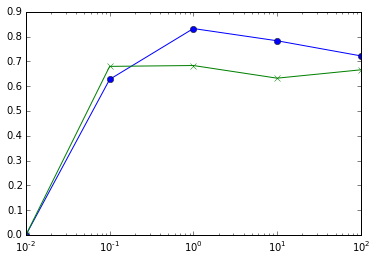

In [209]:
#Do a grid search without calling GridSearchCV
# params = {'clf__C': [0.1, 10] }
C = [0.01, 0.1, 1, 10, 100]
# C = [0.01, 1, 100]
Cplot = []
accuracy = []
accuracyMean = []
recall = []
precision = []
start = time.time()
for currentC in C:
    text_abstract_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
                                  ('tfidf', TfidfTransformer()),
                                  ('clf', LinearSVC(C=currentC,penalty='l1',dual=False))])
#     scores = cross_val_score(text_abstract_clf, all_abstract, all_target, cv=5)
#     accuracy.extend(scores)
    scores = cross_val_score(text_abstract_clf, all_abstract, all_target, cv=5, scoring='recall')
    recall.append(scores.mean())
    scores = cross_val_score(text_abstract_clf, all_abstract, all_target, cv=5, scoring='precision')
    precision.append(scores.mean())
#     accuracyMean.append(scores.mean())
#     Cplot.extend([currentC] * len(scores))

print time.time() - start
# plt.semilogx(Cplot, accuracy, 'o',
#              C, accuracyMean, 'x-')
plt.semilogx(C, recall, 'o-',
             C, precision, 'x-')
# scores = cross_val_score(text_abstract_clf, all_abstract, all_target, cv=5)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# text_abstract_clf.fit(train_abstract, train_target)
# predict_abstract = text_abstract_clf.predict(test_abstract)
# print text_abstract_clf.predict(train_abstract)

In [210]:
print recall
print precision
print C

[0.0, 0.62728785357737105, 0.83227953410981692, 0.7830282861896839, 0.72212978369384362]
[0.0, 0.67973459026163641, 0.68321025790487799, 0.63218215811111, 0.66579728164974161]
[0.01, 0.1, 1, 10, 100]


In [197]:
scores = cross_val_score(text_abstract_clf, all_abstract, all_target, cv=2, scoring='recall')

In [198]:
print scores

[ 0.68928809  0.75299601]


ValueError: x and y must have same first dimension

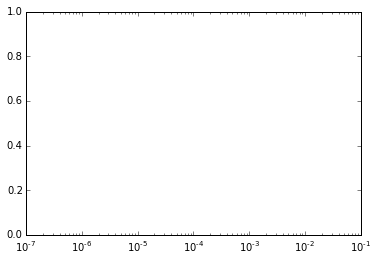

In [211]:
plt.semilogx(Cplot, accuracy, 'o',
             C, accuracyMean, 'x-')

In [181]:
print accuracy
print currentC

[0.87704414115332596, 0.85081785758209327, 0.8782736997417927, 0.80469806911818964]
10


In [141]:
text_abstract_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
                              ('tfidf', TfidfTransformer()),
                              ('clf', LinearSVC(C=3,penalty='l1',dual=False))])
params = {'clf__C': [0.1, 10] }
grid_search = GridSearchCV(text_abstract_clf, params, all_target, cv=2)
grid_search.fit(all_abstract, all_target)
# scores = ['precision', 'recall']

# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# text_abstract_clf.fit(train_abstract, train_target)
# predict_abstract = text_abstract_clf.predict(test_abstract)
# print text_abstract_clf.predict(train_abstract)

TypeError: 'list' object is not callable

In [103]:
# text_title_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
#                               ('tfidf', TfidfTransformer()),
#                               ('clf', MultinomialNB(alpha=.001))])
text_title_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                              ('tfidf', TfidfTransformer()),
                              ('clf', LinearSVC(C=3,penalty='l1',dual=False))])
text_title_clf.fit(train_title, train_target)
predict_title = text_title_clf.predict(test_title)
print text_abstract_clf.predict(train_title)

[0 0 0 ..., 0 0 0]


In [111]:
#SVC(kernel='linear')
print(metrics.classification_report(test_target, predict_abstract,
                                    target_names=test_target_names))
print('Accuracy score: %0.2f' % metrics.accuracy_score(test_target, predict_abstract))

                precision    recall  f1-score   support

           PRL       0.85      0.86      0.85       601
Nature/Science       0.86      0.84      0.85       601

   avg / total       0.85      0.85      0.85      1202

Accuracy score: 0.85


In [114]:
#Am I overfitting?
print(metrics.classification_report(train_target, text_abstract_clf.predict(train_abstract),
                                    target_names=test_target_names))
# print('Accuracy score: %0.2f' % metrics.accuracy_score(test_target, predict_abstract))

                precision    recall  f1-score   support

           PRL       0.94      0.98      0.96     12658
Nature/Science       0.88      0.68      0.76      2404

   avg / total       0.93      0.93      0.93     15062



In [101]:
#SVC(kernel='linear')
print(metrics.classification_report(test_target, predict_title,
                                    target_names=test_target_names))
print('Accuracy score: %0.2f' % metrics.accuracy_score(test_target, predict_title))

                precision    recall  f1-score   support

           PRL       0.56      0.97      0.71       601
Nature/Science       0.90      0.24      0.37       601

   avg / total       0.73      0.60      0.54      1202

Accuracy score: 0.60


In [102]:
print metrics.confusion_matrix(test_target, predict_abstract)

[[536  65]
 [106 495]]


In [ ]:
def inverseVectorizer(val):
    return (key for key, value in text_abstract_clf.named_steps['vect'].vocabulary_.iteritems() if value == val).next()

# This is super inefficient!!!
sorted_coefs = sorted( ( (i,v) for i, v in np.ndenumerate(text_abstract_clf.named_steps['clf'].coef_.todense()) ),
                      key=lambda x: x[1] )
# print sorted_coefs
# print sorted_coefs[-50:]
# print list(reversed(sorted_coefs[-50:]))
print "Top 50 indicators of PRL:"
bottom = sorted_coefs[:50]
print ", ".join([ inverseVectorizer(item[0][1]) for item in bottom])
print ""
print "Top 50 indicators of Nature/Science:"
top = list(reversed(sorted_coefs[-50:]))
print ", ".join([ inverseVectorizer(item[0][1]) for item in top])

In [113]:
print text_abstract_clf.predict(['Here we report quantum information star radio'])
print text_abstract_clf.predict(['We consider a condensate model of tensor squeezing'])

[1]
[0]
